In [ ]:
print("Hello world")  # :)

Hello world


# Binary Classification

## Data

### Create the Data

In [1]:
from sklearn.datasets import make_circles
import numpy as np
import pandas as pd

In [3]:
# Create `make_circle` dataset which is a large circle containing a smaller circle in 2d.
# The goal is classifiying the point in the large circle from the small one.

X, y = make_circles(n_samples=1000, # Number of samples(examples) in each circle(class)
                    noise=0.03,     # the overlap of the points in the two circles
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# Visulize the dataset using pandas in a tabel
data_table = pd.DataFrame({"X1": X[:, 0],
                           "X2": X[:, 1],
                           "y": y})
data_table

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


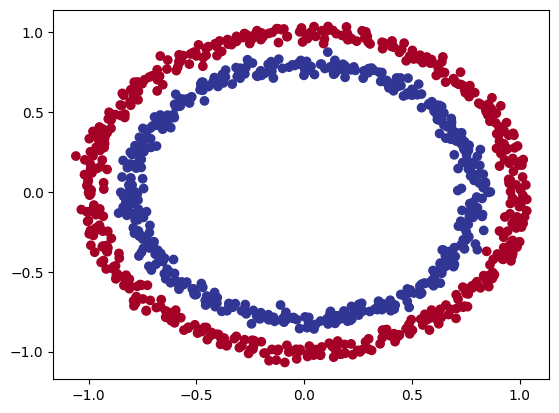

In [8]:
# Visulize using matplotlib
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### Convert the Data to Tensors

In [9]:
type(X)  # We want to convert the numpy to tensor

numpy.ndarray

In [10]:
import torch

X = torch.from_numpy(X).type(torch.float)  # We can write (torch.float32) but it's the same, will return float32
y = torch.from_numpy(y).type(torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

### Split the Data

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## Build the Model 0

In [12]:
# Create a device agonistic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Construct the model

In [13]:
import torch
from torch import nn

torch.manual_seed(42)
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features= 2, out_features=8) # out_features of the first layer must match the in_features in the second one.
    self.layer_2 = nn.Linear(in_features= 8, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [14]:
next(model_0.parameters()).device

device(type='cpu')

### Training Loop

In [15]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.001)

In [16]:
# Create accuracy function; which is dividing the number of correct predictions by the total number of predictions

def accuracy(y_true, y_pred):
  corect = torch.eq(y_true, y_pred).sum().item()   # `torch.eq()` returns who many of these two are eqal
  acc = (corect/len(y_pred)) * 100

  return acc

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100
# put the data on the same device the model on
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create the train loop
for epoch in range(epochs):
  # Training
  # 1. Traing mode
  model_0.train()

  # 2. Model predict
  logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(logits))

  # 3. Loss/Accuracy
  loss = loss_fn(logits, y_train)
  acc = accuracy(y_train, y_preds)

  # 4. Optimizer grad
  optimizer.zero_grad()

  # 5. Loss backward
  loss.backward()

  # 6. Optimization
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_test, test_preds)

  # Print
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Train accuracy {acc} | Test Loss: {test_loss} | Test accuracy: {test_acc}")

Epoch: 0 | Train Loss: 0.7054367661476135 | Train accuracy 48.25 | Test Loss: 0.6949357390403748 | Test accuracy: 53.0
Epoch: 10 | Train Loss: 0.7053729295730591 | Train accuracy 48.25 | Test Loss: 0.6948871612548828 | Test accuracy: 53.0
Epoch: 20 | Train Loss: 0.7053095102310181 | Train accuracy 48.375 | Test Loss: 0.6948390007019043 | Test accuracy: 53.0
Epoch: 30 | Train Loss: 0.7052468061447144 | Train accuracy 48.375 | Test Loss: 0.6947914361953735 | Test accuracy: 53.0
Epoch: 40 | Train Loss: 0.7051844000816345 | Train accuracy 48.25 | Test Loss: 0.694744348526001 | Test accuracy: 53.5
Epoch: 50 | Train Loss: 0.7051225900650024 | Train accuracy 48.25 | Test Loss: 0.6946977972984314 | Test accuracy: 53.5
Epoch: 60 | Train Loss: 0.7050612568855286 | Train accuracy 48.25 | Test Loss: 0.6946516633033752 | Test accuracy: 53.5
Epoch: 70 | Train Loss: 0.7050004601478577 | Train accuracy 48.25 | Test Loss: 0.6946061849594116 | Test accuracy: 53.5
Epoch: 80 | Train Loss: 0.70494008064270

## Evaluate the model

### Helper function

In [18]:
! wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
from helper_functions import plot_predictions, plot_decision_boundary

--2024-01-26 19:00:13--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-01-26 19:00:13 (91.9 MB/s) - ‘helper_functions.py’ saved [10160/10160]



### PLot the decsiosn boundary

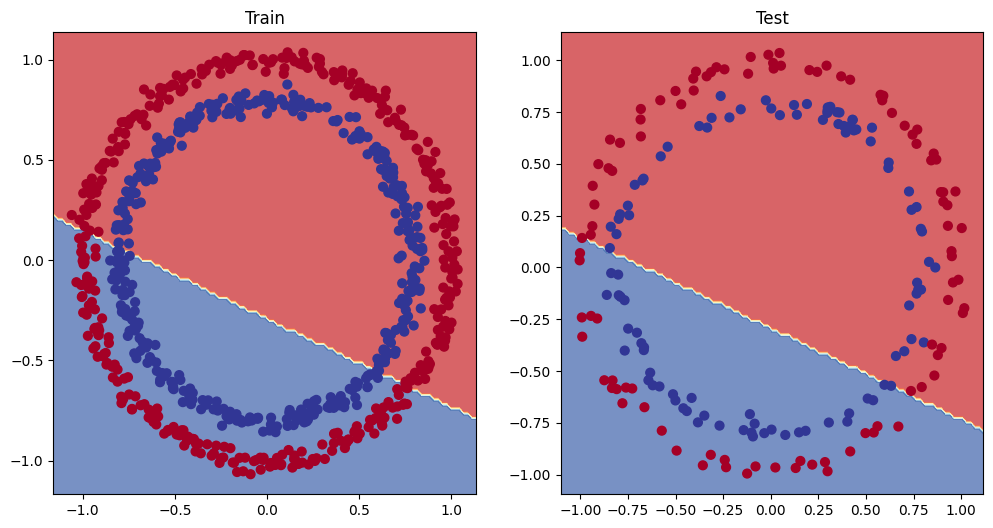

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

The linear line can't separate the points in this dataset effectively. We need to use a non-linear boundary to achieve better accuracy.

## BUild the Model 1: Non-linearity

### Construct the Model

In [24]:
from torch import nn
# Model class
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 512)
    self.layer_2 = nn.Linear(512, 512)
    self.relu = nn.ReLU()
    self.layer_3 = nn.Linear(512, 1)

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)

    return x

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu): ReLU()
  (layer_3): Linear(in_features=512, out_features=1, bias=True)
)

### Training Loop

In [25]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.01)

In [26]:
torch.manual_seed(42)

epochs = 1000
# Move the dataset to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  # 1. train mode
  model_1.train()
  # 2. predict
  logits_1 = model_1(X_train).squeeze()
  preds = torch.round(torch.sigmoid(logits_1))
  # 3. Loss/Accuracy
  loss = loss_fn(logits_1, y_train)
  acc = accuracy(y_train, preds)
  # 4. optimizer zero grad
  optimizer.zero_grad()
  # 5. Backward
  loss.backward()
  # 6. Optimizer step
  optimizer.step()

  # Testing
  model_1.eval()
  with torch.inference_mode():
    logits = model_1(X_test).squeeze()
    preds = torch.round(torch.sigmoid(logits))
    test_loss = loss_fn(logits, y_test)
    test_acc = accuracy(y_test, preds)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Train accuracy {acc} | Test Loss: {test_loss} | Test accuracy: {test_acc}")

Epoch: 0 | Train Loss: 0.6945662498474121 | Train accuracy 50.0 | Test Loss: 0.6969695091247559 | Test accuracy: 50.0
Epoch: 10 | Train Loss: 0.6930441856384277 | Train accuracy 48.0 | Test Loss: 0.695527970790863 | Test accuracy: 47.5
Epoch: 20 | Train Loss: 0.6918383836746216 | Train accuracy 46.125 | Test Loss: 0.6944168210029602 | Test accuracy: 45.5
Epoch: 30 | Train Loss: 0.6907379627227783 | Train accuracy 50.875 | Test Loss: 0.6934173107147217 | Test accuracy: 50.0
Epoch: 40 | Train Loss: 0.689667284488678 | Train accuracy 51.74999999999999 | Test Loss: 0.6924606561660767 | Test accuracy: 52.0
Epoch: 50 | Train Loss: 0.6886290907859802 | Train accuracy 54.125 | Test Loss: 0.69154953956604 | Test accuracy: 53.0
Epoch: 60 | Train Loss: 0.6875725388526917 | Train accuracy 55.875 | Test Loss: 0.6906294226646423 | Test accuracy: 53.5
Epoch: 70 | Train Loss: 0.686549961566925 | Train accuracy 58.75 | Test Loss: 0.6897528767585754 | Test accuracy: 56.49999999999999
Epoch: 80 | Train L

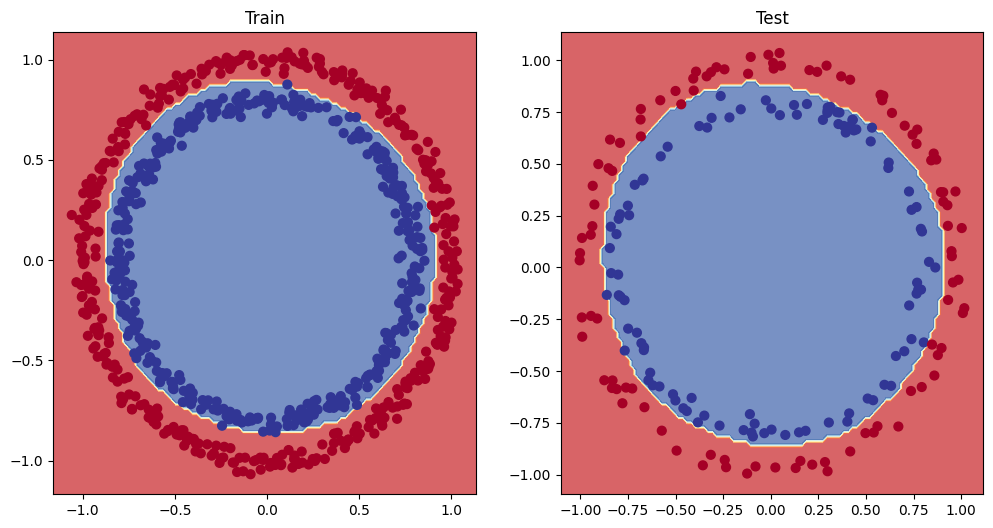

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Due to chat-gpt ReLU is a piecewise linear function, meaning it has different linear behaviors (slopes) in different regions of its input. Specifically, for input values less than zero, it has a slope of zero (flat), and for input values greater than zero, it has a slope of one (45-degree line).

## Relu and Sigmoid function

In [28]:
A = torch.arange(-10, 10, 1, dtype=torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

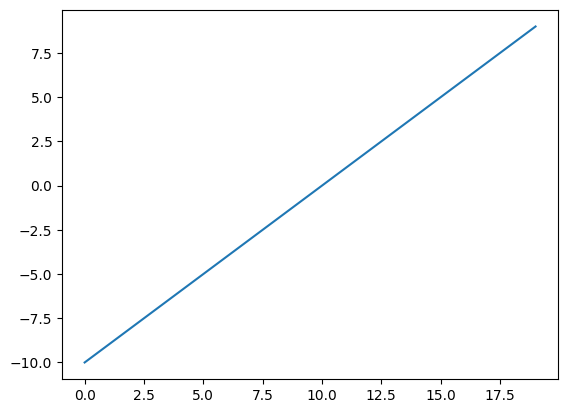

In [29]:
import matplotlib.pyplot as plt

plt.plot(A)

### ReLU
f(x) = max(0,x)

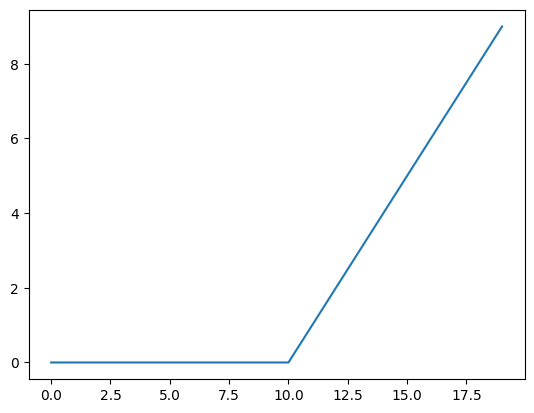

In [30]:
plt.plot(torch.relu(A));

### Sigmoid

S = 1 / (1+e^(-x))

e or also known as Euler's number, is a mathematical constant approximately equal to 2.71828

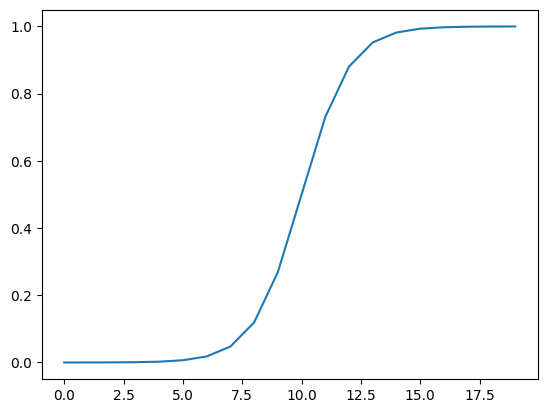

In [31]:
plt.plot(torch.sigmoid(A))

# MultiClass classification

## Make Blobs Dataset
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

In [33]:
from sklearn.datasets import make_blobs   #فقاقيع
import torch
import matplotlib.pyplot as plt

In [34]:
X, y = make_blobs(n_samples= 1000, # number of sample
                  n_features= 2,   # number of feature
                  centers=5,       # number of classes
                  cluster_std= 2.1,# std
                  random_state= 42)

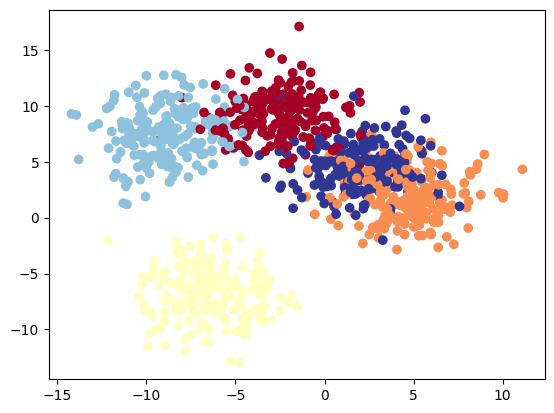

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [36]:
type(X)

numpy.ndarray

In [37]:
# Turn it to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)
X.dtype, y.dtype

(torch.float32, torch.int64)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## The Model

In [39]:
# Device agnostice code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Constructe

In [40]:
from torch import nn
class BlobsModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 512)
    self.layer_2 = nn.Linear(512, 512)
    self.layer_3 = nn.Linear(512, 5)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.layer_3(x)

    return x

model_2 = BlobsModel().to(device)
model_2

BlobsModel(
  (layer_1): Linear(in_features=2, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=5, bias=True)
  (relu): ReLU()
)

### Loss, optimizer and accuracy function

In [41]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.01)

In [42]:
def accuracy(y_true, y_pred):
  corect = torch.eq(y_true, y_pred).sum().item()   # `torch.eq()` returns who many of these two are eqal
  acc = (corect/len(y_pred)) * 100

  return acc

### Training loop

In [43]:
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  # 1. train mode
  model_2.train()
  # 2. predict
  logits = model_2(X_train)
  preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
  # 3. loss/accuracy
  loss = loss_fn(logits, y_train)
  acc = accuracy(y_train, preds)
  # 4. optimizer
  optimizer.zero_grad()
  # 5. backward
  loss.backward()
  # 6. Optimizer
  optimizer.step()
  model_2.eval()
  with torch.inference_mode():
    logits = model_2(X_test)
    preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
    test_loss = loss_fn(logits, y_test)
    test_acc = accuracy(y_test, preds)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Train Loss: {loss} | Train accuracy {acc} | Test Loss: {test_loss} | Test accuracy: {test_acc}")

Epoch: 0 | Train Loss: 1.6994521617889404 | Train accuracy 8.625 | Test Loss: 1.014831304550171 | Test accuracy: 53.0
Epoch: 20 | Train Loss: 0.4215152859687805 | Train accuracy 85.25 | Test Loss: 0.419413298368454 | Test accuracy: 84.0
Epoch: 40 | Train Loss: 0.3806883692741394 | Train accuracy 85.625 | Test Loss: 0.3806616961956024 | Test accuracy: 84.0
Epoch: 60 | Train Loss: 0.366202712059021 | Train accuracy 85.875 | Test Loss: 0.36689817905426025 | Test accuracy: 84.0
Epoch: 80 | Train Loss: 0.3583639860153198 | Train accuracy 85.875 | Test Loss: 0.35963156819343567 | Test accuracy: 84.0
Epoch: 100 | Train Loss: 0.35307300090789795 | Train accuracy 85.875 | Test Loss: 0.3549021780490875 | Test accuracy: 84.5
Epoch: 120 | Train Loss: 0.3490419089794159 | Train accuracy 85.75 | Test Loss: 0.3513428866863251 | Test accuracy: 84.5
Epoch: 140 | Train Loss: 0.3457331955432892 | Train accuracy 85.875 | Test Loss: 0.34848839044570923 | Test accuracy: 85.0
Epoch: 160 | Train Loss: 0.34295

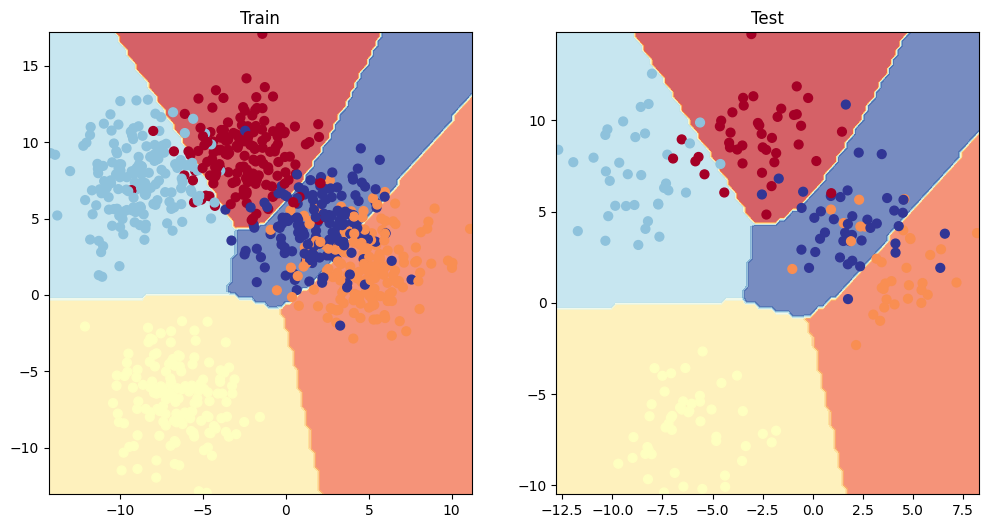

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)